In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
SETTINGS = json.load(open("settings.json"))
FORCE_RECOMPUTE = False

In [ ]:
chat0 = SETTINGS["download"]["from_chats"][0]
CHAT0 = pd.read_csv(f"{chat0}.csv", parse_dates=["date"])

chat1 = SETTINGS["download"]["from_chats"][1]
CHAT1 = pd.read_csv(f"{chat1}.csv", parse_dates=["date"])

CHATS = pd.concat([CHAT0, CHAT1])
CHAT0_LEN = len(CHAT0)
CHAT1_LEN = len(CHAT1)
del CHAT0, CHAT1

In [ ]:
from detoxify import Detoxify

model1 = Detoxify("multilingual", device="cuda")

In [ ]:
from transformers import pipeline

model2 = pipeline(model="SkolkovoInstitute/russian_toxicity_classifier", device="cuda")

In [ ]:
a = model1.predict(["приветик", "как делишки?"])
b = model2(["приветик", "как делишки?"], return_all_scores=True)
a, b

In [ ]:
def model1_predict(x: pd.Series):
    BATCH_SIZE = 64
    TARGET_KEYS = ["toxicity", "severe_toxicity", "identity_attack", "insult", "threat"]
    scores = np.zeros((len(x),))
    for i in range(0, len(x), BATCH_SIZE):
        batch = list(x[i : i + BATCH_SIZE])
        pred = model1.predict(list(batch))
        pred_filtered = np.array([pred[key] for key in TARGET_KEYS])
        batch_scores = np.max(pred_filtered, axis=0)
        scores[i : i + BATCH_SIZE] = batch_scores
    return scores


model1_predict(pd.Series(["приветик", "как делишки?"]))

In [ ]:
def model2_predict(x: pd.Series):
    return [
        next(row["score"] for row in verdict if row["label"] == "toxic")  # type: ignore
        for verdict in model2(list(x), top_k=None, truncation=True)  # type: ignore
    ]


model2_predict(pd.Series(["приветик", "как делишки?"]))

In [ ]:
import os

if not os.path.exists(f"chats.parquet") or FORCE_RECOMPUTE:
    CHATS["toxicity_1"] = model1_predict(CHATS["message"])
    CHATS["toxicity_2"] = model2_predict(CHATS["message"])
    CHATS.to_parquet(f"chats.parquet")
else:
    CHATS = pd.read_parquet(f"chats.parquet")

In [ ]:
# group toxicity by day (take max)
from functools import partial

q = partial(np.quantile, q=0.95)

by_day = CHATS.groupby(CHATS["date"].dt.date)
# by_day.agg({"toxicity_1": "max", "toxicity_2": "max"}).plot()
ax = by_day.agg({"toxicity_1": q, "toxicity_2": q}).plot()
plt.xticks(rotation=90)
plt.show()

Watch 13-17 and 21-25!

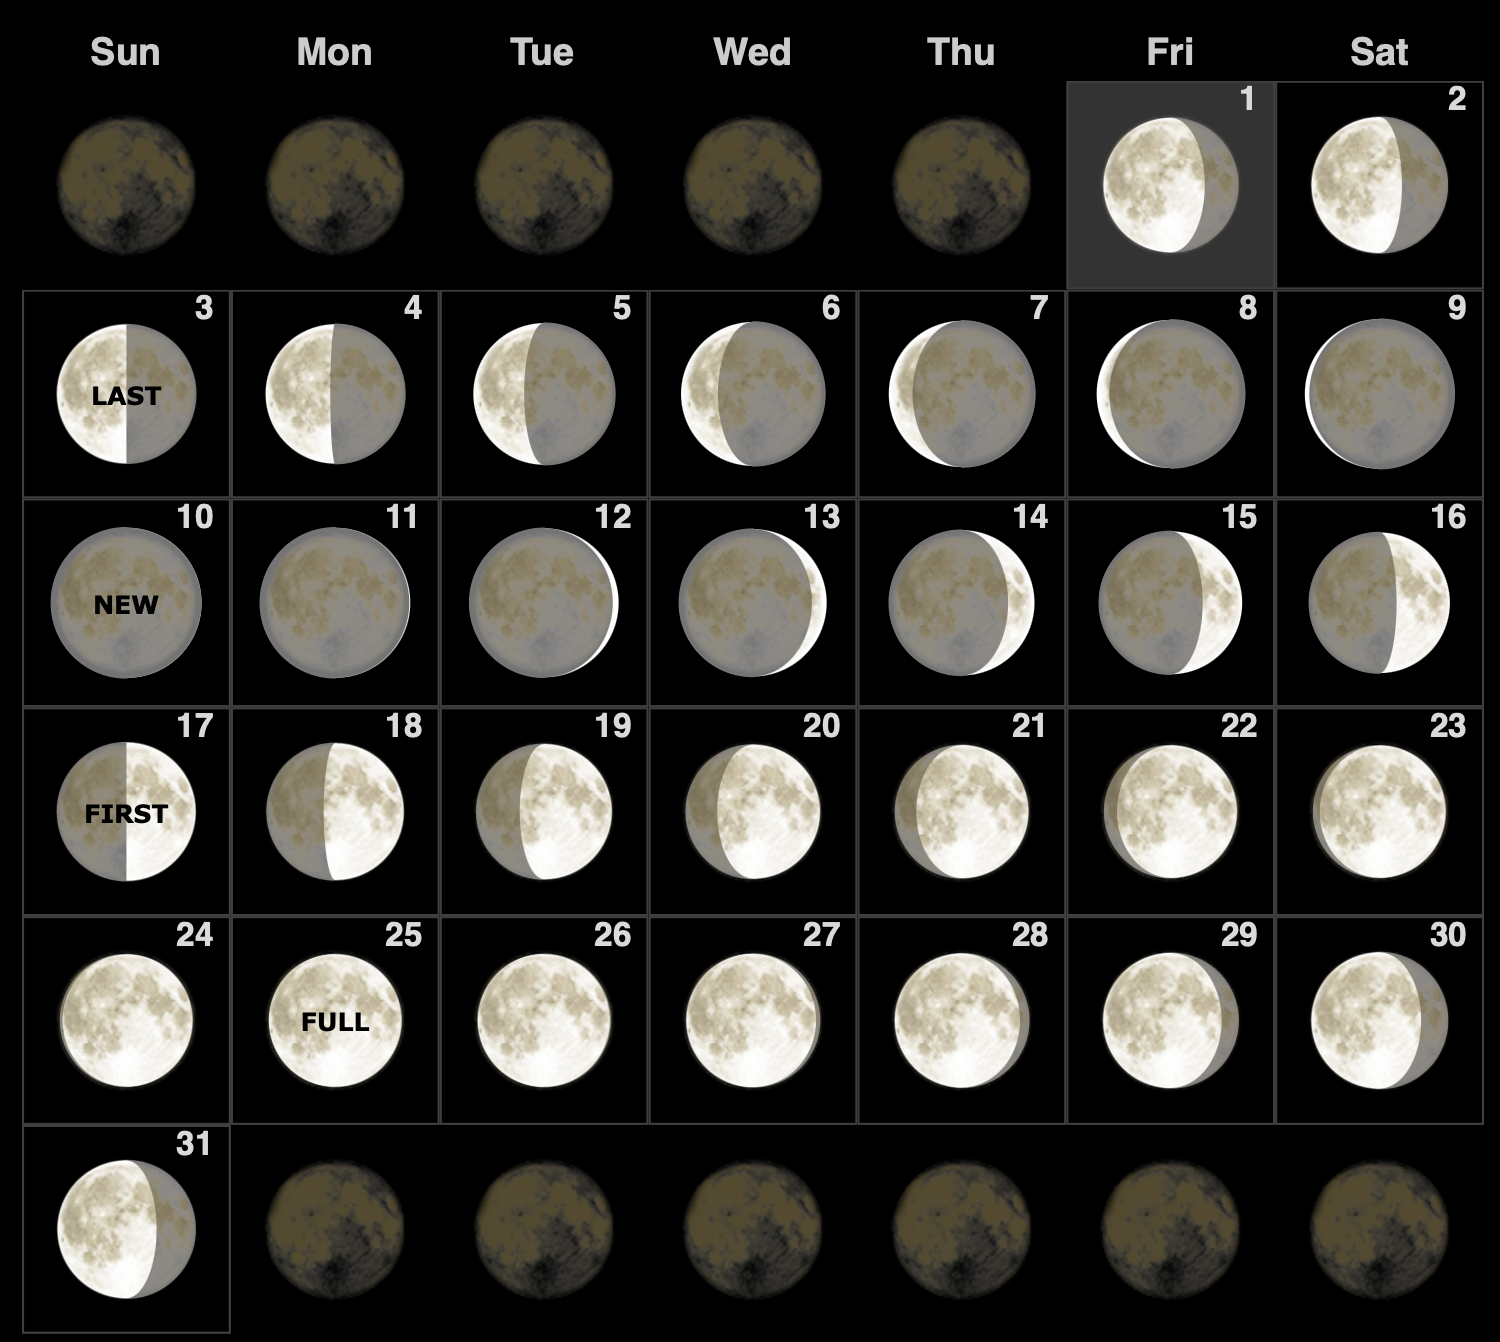

In [ ]:
# group toxocity by from_id

q = partial(np.percentile, q=95)

by_from_id = CHATS.groupby("from_id")
agg = by_from_id.agg({"toxicity_1": q, "toxicity_2": q})

agg_1 = agg.sort_values("toxicity_1", ascending=False)
ax = agg_1.plot.bar()
# ax.set_xticklabels(
#     ["King", "Queen", "Joker"] + ["███" for _ in range(len(ax.get_xticks()) - 3)]
# )
ax.plot()

agg_2 = agg.sort_values("toxicity_2", ascending=False)
ax = agg_2.plot.bar()
# ax.set_xticklabels(
#     ["King", "Queen", "Joker"] + ["███" for _ in range(len(ax.get_xticks()) - 3)]
# )
ax.plot()

In [ ]:
# by_from_id.aggregate({"toxicity_1": "mean", "toxicity_2": "mean"}).sort_values(
#     "toxicity_1"
# )

In [ ]:
from_ids = set(CHATS["from_id"])

In [ ]:
# check if exists
if not os.path.exists(f"id2username.parquet") or FORCE_RECOMPUTE:
    import telethon

    from_usernames = []
    async with telethon.TelegramClient(
        telethon.sessions.StringSession(os.environ["TELEGRAM_SESSION_TELETHON"]),
        int(os.environ["TELEGRAM_API_ID"]),
        os.environ["TELEGRAM_API_HASH"],
    ) as tg:
        await tg.get_messages(chat0, limit=CHAT0_LEN)
        await tg.get_messages(chat1, limit=CHAT1_LEN)
        for id in from_ids:
            user = await tg.get_entity(id)
            username = user.username or user.first_name
            from_usernames.append(username)

    id2username = pd.DataFrame({"id": list(from_ids), "username": from_usernames})
    id2username.to_parquet(f"id2username.parquet")
else:
    id2username = pd.read_parquet(f"id2username.parquet")

In [ ]:
pd.merge(agg_1, id2username, left_on="from_id", right_on="id").iloc[:5]

In [ ]:
pd.merge(agg_2, id2username, left_on="from_id", right_on="id").iloc[:5]

In [ ]:
by_from_id

In [ ]:
# group toxocity by from_id

Q = CHATS[["toxicity_1", "toxicity_2"]].quantile(0.95)

# q = partial(np.percentile, q=95)

by_from_id = CHATS[
    (CHATS["toxicity_1"] > Q["toxicity_1"]) | (CHATS["toxicity_2"] > Q["toxicity_2"])
].groupby("from_id")
agg = by_from_id.agg({"toxicity_1": "median", "toxicity_2": "median"})

agg_1 = agg.sort_values("toxicity_1", ascending=False)
ax = agg_1.plot.bar()
# ax.set_xticklabels(
#     ["King", "Queen", "Joker"] + ["███" for _ in range(len(ax.get_xticks()) - 3)]
# )
ax.plot()

agg_2 = agg.sort_values("toxicity_2", ascending=False)
ax = agg_2.plot.bar()
# ax.set_xticklabels(
#     ["King", "Queen", "Joker"] + ["███" for _ in range(len(ax.get_xticks()) - 3)]
# )
ax.plot()

In [ ]:
pd.merge(agg_1, id2username, left_on="from_id", right_on="id").iloc[:5]

In [ ]:
pd.merge(agg_2, id2username, left_on="from_id", right_on="id").iloc[:5]

In [ ]:
CHATS[["toxicity_1", "toxicity_2"]].corr().iloc[0, 1]

In [ ]:
Q = CHATS[["toxicity_1", "toxicity_2"]].quantile(0.995)
Q

In [ ]:
CHATS[(CHATS[["toxicity_1", "toxicity_2"]] > Q).max(axis=1)]["message"]

In [ ]:
from transformers import pipeline

model_sentiment = pipeline(
    model="blanchefort/rubert-base-cased-sentiment", device="cuda"
)

In [ ]:
def model_sentiment_predict(x: pd.Series):
    return [
        next(row["score"] for row in verdict if row["label"] == "NEGATIVE")  # type: ignore
        for verdict in model_sentiment(list(x), top_k=None, truncation=True)  # type: ignore
    ]


model_sentiment_predict(pd.Series(["приветик", "как делишки?"]))